In [1]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import numpy as np
import glob
from skimage.feature import hog

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
% matplotlib inline


/Users/ankitgrover/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
## Import everything from helpers
from helpers.utils import Utils
from helpers.filterFalsePositive import FilterFalsePositive
from helpers.classify import ClassifierUtil

In [3]:
car_images_files = glob.glob('helpers/train_images/vehicles/**/*.png', recursive = True)
not_car_images_files = glob.glob('helpers/train_images/non-vehicles/**/*.png', recursive = True)
classifier_util = ClassifierUtil()
svc, X_scaler = classifier_util.run_classifier(car_images_files, not_car_images_files)

Reading all the images
Car images files 8792
8792
8968
(17760, 17856)
Feature vector length:  17856
Count of Train data:  14208
25  seconds to train SVC
Accuracy of the model is 0.99


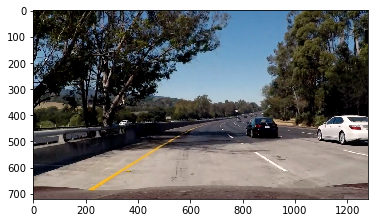

In [4]:
## Original testing image
img = mpimg.imread('test_images/test5.jpg')
plt.imshow(img)

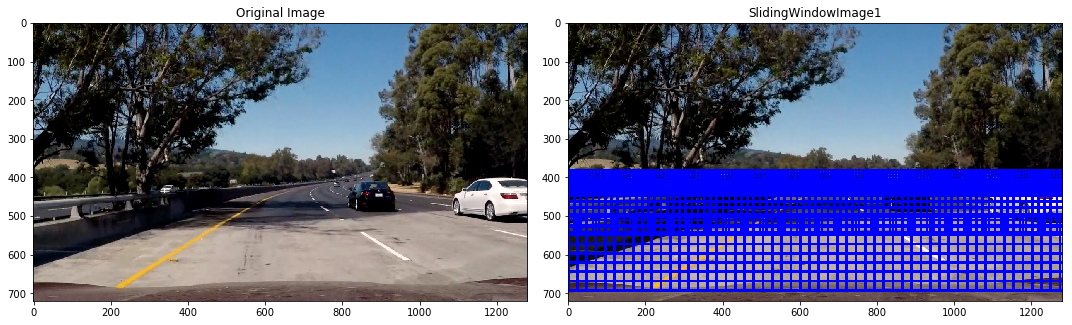

In [5]:
utils = Utils()
## Multiscale windows Visualization
scale_windows_list = []
scale_size = 4
y_starts = [380, 430, 500]
y_stops = [430, 520, 660]

for window_scale in range (1, scale_size):
    window_dimen = 32 * window_scale
    ##print (window_dimen)
    windows_list = utils.slide_window(img, x_start_stop=[None, None], y_start_stop=[y_starts[window_scale -1], y_stops[window_scale -1]], 
                    xy_window=(window_dimen, window_dimen), xy_overlap=(0.75, 0.75))
    if (len(scale_windows_list) == 0):
        scale_windows_list = windows_list
    else :
        scale_windows_list = scale_windows_list + windows_list
    
draw_img = np.copy(img)
#print (scale_windows_list[len(scale_windows_list) -1])
for window in scale_windows_list:
    cv2.rectangle(draw_img, window[0], window[1],(0,0,255),6)
    
fig = plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(draw_img)
plt.title('SlidingWindowImage1')
fig.tight_layout()

In [6]:
## Parameters that will help in finding cars in the image.
scale_size = 4
#y_starts = [380, 430, 500]
#y_stops = [430, 520, 660]
#scales = [1.5,2.5,3]
y_start = 400
y_stop = 656
scale = 1.8
orient = 12
pix_per_cell = 8
cell_per_block = 4
spatial_size = (32, 32)
hist_bins = 128

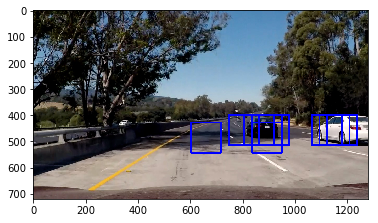

In [7]:
def find_cars(image):
    return utils.find_cars(image, y_start, y_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, window = 64)   
    
draw_img, bboxes = find_cars(img)
plt.imshow(draw_img)

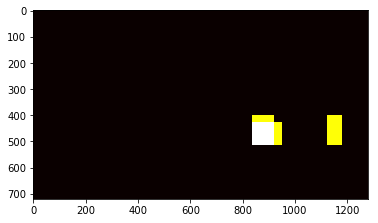

In [8]:
def filter_false_positives(image, bboxes_list):
    filter_false_positive = FilterFalsePositive()
    heat = filter_false_positive.convert_img_to_heat(image)
    #print (bboxes)
    heatmap = filter_false_positive.add_heat(bboxes_list)
    heatmap = filter_false_positive.threshold(threshold = 3)
    return heatmap, filter_false_positive
    
heatmap, filter_false_positive = filter_false_positives(img, bboxes)
plt.imshow(heatmap, cmap='hot')

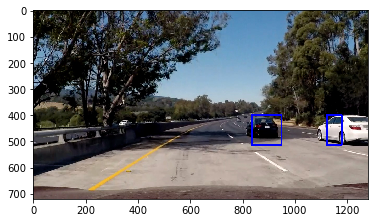

In [9]:
def labels(image, filter_false_positive):
    filter_false_positive.labels()
    labeled_img = filter_false_positive.draw_labeled_bboxes(image)
    return labeled_img

labeled_img = labels(img, filter_false_positive)
plt.imshow(labeled_img)

In [10]:
def process_image(frame):
    draw_img, bboxes = find_cars(frame)
    heatmap, filter_false_positive = filter_false_positives(frame, bboxes)
    output_frame = labels(frame, filter_false_positive)
    return output_frame

In [11]:
from moviepy.editor import VideoFileClip
output_video_path = 'output_video/test_video_output.mp4'
input_clip = VideoFileClip("test_video.mp4")
output_clip = input_clip.fl_image(process_image)
%time output_clip.write_videofile(output_video_path, audio=False)

[MoviePy] >>>> Building video output_video/test_video_output.mp4
[MoviePy] Writing video output_video/test_video_output.mp4


 97%|█████████▋| 38/39 [00:09<00:00,  4.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/test_video_output.mp4 

CPU times: user 8.21 s, sys: 907 ms, total: 9.11 s
Wall time: 10.5 s
